#Contexte et objectif

**Objectif** : Prévoir si une exploitation agricole est saine (DIFF=1) ou défaillante (DIFF=0) en s’appuyant sur 6 variables (R2, R7, R8, R17, R22, R32) décrivant la situation économique et financière des exploitations.

**Données et méthode**

Données : 399 observations, répartition proche de l’équilibre entre les deux classes (environ 213 saines et 186 défaillantes).

**Modèle** : Utilisation du modèle XGBoost, largement reconnu pour sa performance en classification.

**Validation** : Validation croisée (k=5) afin d’obtenir une estimation robuste de la performance. Critère principal : l’AUC (aire sous la courbe ROC).

# XGboost : Présentation

XGBoost (Extreme Gradient Boosting) est une bibliothèque d’algorithmes de machine learning basée sur la technique du gradient boosting, appliquée sur des arbres de décision. Le principe du gradient boosting consiste à entraîner successivement une série de modèles simples (le plus souvent, de petits arbres de décision) où chaque nouveau modèle cherche à corriger les erreurs du précédent. Au fil des itérations, ces arbres s’additionnent afin de créer un modèle final très performant. XGBoost se distingue par son efficacité en termes de rapidité, de gestion de la mémoire et de qualité de prédiction, notamment grâce à l’optimisation poussée de son code, à des techniques de régularisation pour éviter le surapprentissage, et à la prise en charge du parallélisme.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import shap

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV


In [8]:
data = pd.read_csv("farms_train.csv", sep=';', decimal=',')

for col in ['R2', 'R7', 'R8', 'R17', 'R22', 'R32']:
    data[col] = data[col].str.replace(',', '.').astype(float)

data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DIFF    398 non-null    int64  
 1   R2      398 non-null    float64
 2   R7      398 non-null    float64
 3   R8      398 non-null    float64
 4   R17     398 non-null    float64
 5   R22     398 non-null    float64
 6   R32     398 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 21.9 KB


In [17]:
X = data[['R2', 'R7', 'R8', 'R17', 'R22', 'R32']]
y = data['DIFF']

model = XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score AUC :", grid_search.best_score_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Meilleurs hyperparamètres : {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}
Meilleur score AUC : 0.9344976205441322


In [19]:
calibrated_model = CalibratedClassifierCV(estimator=best_model, method='sigmoid', cv=cv)
calibrated_model.fit(X, y)

auc_scores_calibrated = cross_val_score(calibrated_model, X, y, scoring='roc_auc', cv=cv)
print("AUC par fold avec calibration :", auc_scores_calibrated)
print("AUC moyenne avec calibration :", auc_scores_calibrated.mean())

AUC par fold avec calibration : [0.87554997 0.93023256 0.95725959 0.95817246 0.93500644]
AUC moyenne avec calibration : 0.931244201011643


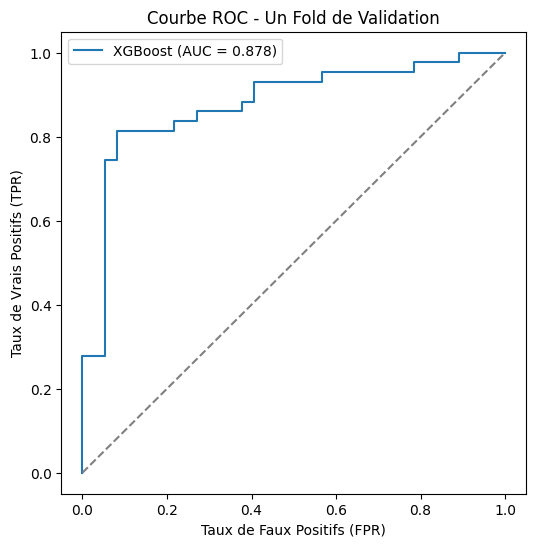

In [23]:
# On récupère le premier fold (train_index, test_index)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    break  # On sort de la boucle après le premier split

# Entraînement du modèle sur le premier fold
model.fit(X_train, y_train)

# Prédictions probabilistes
y_proba = model.predict_proba(X_test)[:, 1]

# Calcul des points pour la courbe ROC et de l'AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Tracé de la courbe ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='XGBoost (AUC = {:.3f})'.format(auc))
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC - Un Fold de Validation')
plt.legend()
plt.show()

# Résultats de performance
**AUC en validation croisée** : Environ 0.93, indiquant une excellente capacité discriminante du modèle.

**Courbe ROC** : La courbe ROC montre qu’à chaque niveau de sensibilité, le taux de faux positifs est maintenu relativement bas. L’AUC élevée confirme les bonnes performances du modèle.

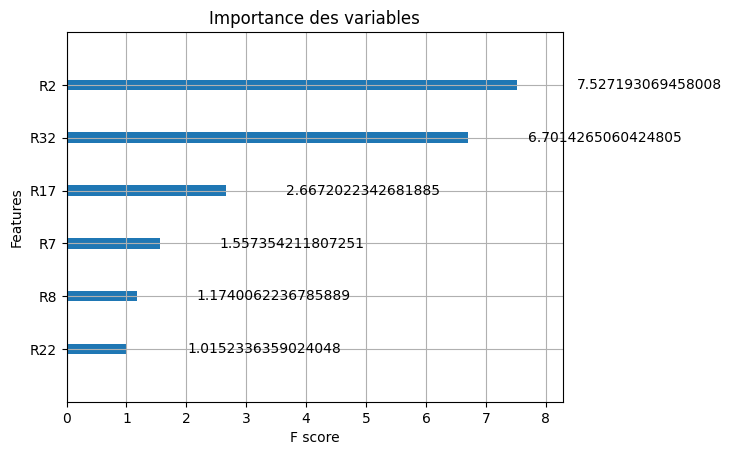

In [20]:
plot_importance(best_model, importance_type='gain')
plt.title("Importance des variables")
plt.show()

In [21]:
feature_importances = best_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

print(importance_df)

  Feature  Importance
0      R2    0.364647
5     R32    0.324644
3     R17    0.129210
1      R7    0.075444
2      R8    0.056873
4     R22    0.049182


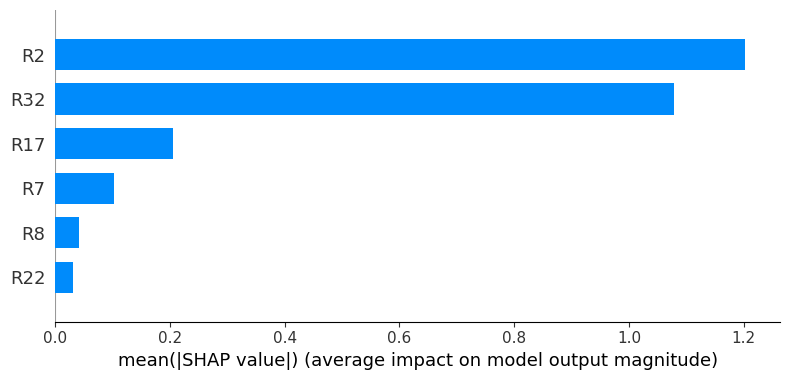

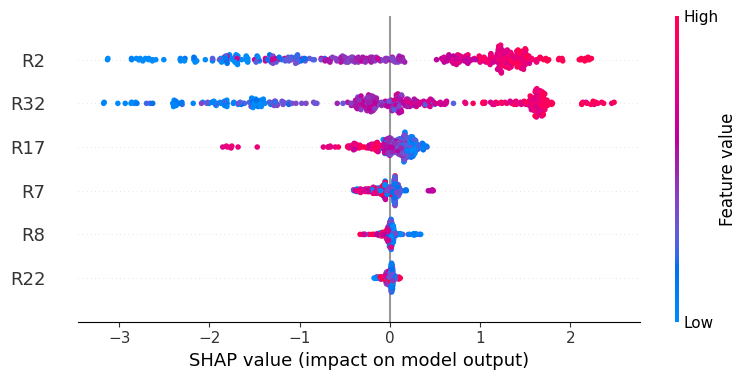

In [22]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)

# Diagramme récapitulatif (barres) de l’importance globale
shap.summary_plot(shap_values, X, plot_type="bar")

# Diagramme récapitulatif (nue de points) pour voir l'effet de chaque variable
shap.summary_plot(shap_values, X)

#Interprétation du modèle
Pour mieux comprendre pourquoi le modèle est performant, nous nous sommes intéressés à l’importance des variables et à leur contribution aux prédictions.

**Importance des variables** (Feature Importance XGBoost)
Le graphique d’importance met en évidence que les variables R2 et R32 sont les plus déterminantes. Elles jouent un rôle clé dans la discrimination entre exploitations saines et défaillantes. R17, R7, R8 et R22 ont également un impact, mais moindre.

Cette importance est fondée sur la façon dont les arbres du modèle utilisent ces variables pour séparer au mieux les classes.

**Valeurs SHAP**
Les valeurs SHAP (Figures ci-jointes) offrent une interprétation plus fine.

**SHAP Bar Plot** : La figure bar chart montre de façon similaire que R2 et R32 ont le plus fort impact moyen sur la sortie du modèle.

**SHAP Summary Plot** (nuage de points) : Chaque point représente une observation, la couleur indique la valeur de la variable (bleu=faible, rose=élevée). La position sur l’axe horizontal indique l’impact sur la prédiction (vers la droite : favorise la probabilité d’être « sain »).

On observe que :

De fortes valeurs de R2 et R32 (points rosés à droite) semblent associés à une plus grande probabilité d’être sain.
R17, R7, R8 et R22 ont des effets plus modérés et variables.